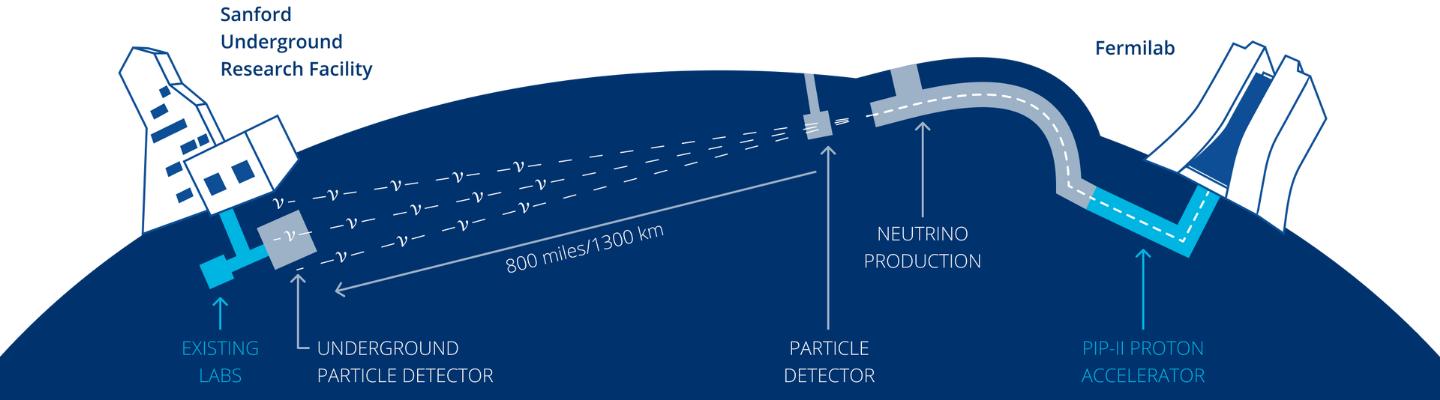

# <a id='toc1_'></a>[Analysis of Real Data from the PDHD Detector](#toc0_)
This notebook focuses on the run 32974, event=56, collection plane.

Once you're comfortable with the simplified MC data, the next step is to analyze real data collected by the ProtoDUNE Horizontal Drift (PDHD) detector. 

As a surface detector, PDHD is continuously bombarded by cosmic rays, resulting in multiple overlapping tracks within each recorded event. For these data dead channels (overactivity with no real physical signal) have already been masked.

**Table of contents**<a id='toc0_'></a>    
- [Analysis of Real Data from the PDHD Detector](#toc1_)    
  - [Loading the libraries, files and style of the notebook](#toc1_1_)    
  - [Characteristics of a single run, single event, collection plane hits of a single TPC.](#toc1_2_)    
  - [Looking into thresholds and noise removal](#toc1_3_)    
  - [Spatial distribution](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Loading the libraries, files and style of the notebook](#toc0_)

In [ ]:
import uproot #Uproot is a Python library that allows you to read, write, and manipulate ROOT files without requiring ROOT or C++.
import awkward as ak #this is for ragged data handling, which is common in particle physics data
import pandas as pd
%matplotlib widget  #Enables zoom, pan, and live updates in matplotlib figures
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore') # Ignore warnings for cleaner output

filepath = "../data/pdhd_run032974_tps.root"    

with uproot.open(filepath) as file:
    tree = file["triggerana/tree"]  # Adjust the path if your tree is elsewhere
    print(tree.keys())  # This prints all branch names in the tree

['event', 'run', 'subrun', 'TP_channel', 'TP_startT', 'TP_peakT', 'TP_TOT', 'TP_SADC', 'TP_peakADC', 'TP_plane', 'TP_TPC']


In [ ]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../custom.css", "r").read()
    return HTML(styles)

In [10]:
#instead of using all the branches, we can specify which ones we want to read
def load_data(filepath, branch_names, max_events=3000):
    """Load data from a ROOT file into a pandas DataFrame."""
    try:
        with uproot.open(filepath) as file:
            tree = file["triggerana/tree"]
            arrays = tree.arrays(branch_names, library="ak", entry_stop=max_events)
            return ak.to_dataframe(arrays)
    except Exception as e:
        print(f"Error loading data from {filepath}: {e}")
        return None

# name of branches in the TTree to read into the pandas df
TP_BRANCHES_df = ['event', 'run', 'subrun', 'TP_channel', 'TP_startT', 'TP_peakT', 'TP_TOT', 'TP_SADC', 'TP_peakADC', 'TP_plane', 'TP_TPC'] #trigger primitives for real data

In [11]:
#Let's load the data from runs
df_32974= load_data(filepath, TP_BRANCHES_df, 10000)
df_32974.run_name = "Cosmic run 32974"

In [12]:
triggers = df_32974.event.unique()
print(f"Event {triggers}")

Event [  8  16  24  32  40  48  56  64  72  80  88  96 104 112 120 128 136 144
 152 160 168 176 184 192 200 208 216 224 232 240 248 256 264 272 280 288
 296 304 360 368]


In [6]:
# Global variable for APA ranges
apa_ranges = {
    "APA1": (0, 2560),
    "APA3": (2560, 5120),
    "APA2": (5120, 7680),
    "APA4": (7680, 10240),
}

In [7]:
event=56
plane=2

def make_title(run, event, plane, cuts="no cuts"):
    return f"Run {run} | Event {event} | Plane {plane} | {cuts}"

## <a id='toc1_2_'></a>[Characteristics of a single run, single event, collection plane hits of a single TPC.](#toc0_)

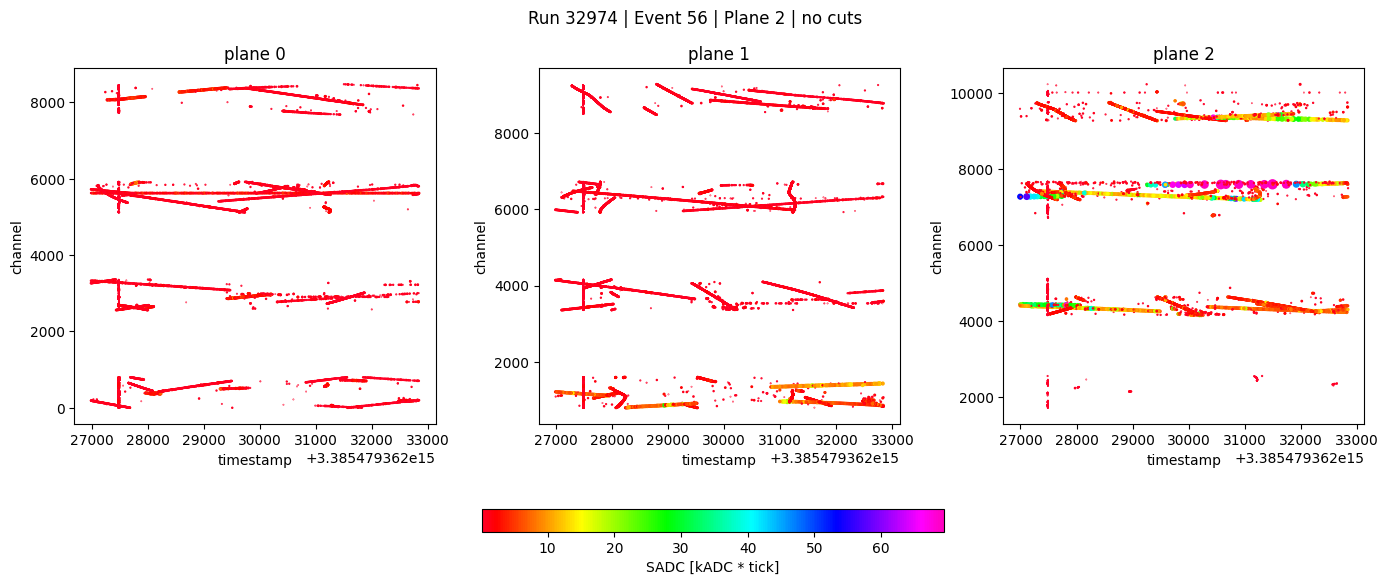

In [7]:
#timestamps correspond to nanoseconds, the big number is the first detection hit in timestamp
# Note: APA1 collection plane is broken so we will not use it in this analysis.

tps_32974 = df_32974[(df_32974.event == event)]
tps_32974.run_name = "Cosmic run 32974"
vmin, vmax = tps_32974["TP_SADC"].min()/1e3, (tps_32974["TP_SADC"].max()/1e3)/2
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

for plane in range(3):
    tps = tps_32974[tps_32974.TP_plane == plane]
    sc = ax[plane].scatter(tps.TP_peakT, tps.TP_channel, s=tps.TP_TOT / 10, c=tps.TP_SADC/1e3, cmap='gist_rainbow', vmin=vmin, vmax=vmax)
    ax[plane].set_xlabel("timestamp")
    ax[plane].set_ylabel("channel")
    ax[plane].set_title(f"plane {plane}")   
    
plt.suptitle(make_title(tps['run'].unique()[0], event, plane))
fig.colorbar(sc, ax=ax, orientation='horizontal', fraction=0.05, pad=-0.3).set_label("SADC [kADC * tick]")
plt.tight_layout()
plt.show()

- Induction planes appear to be noisier and have less SADC variations.
- Increased noise due to pile-up of simultaneous activity.
- More variable noise levels compared to MC simulations, and noisy/dead channels (which can change across multiple trigger records, as the data taking conditions are never exactly the same!)

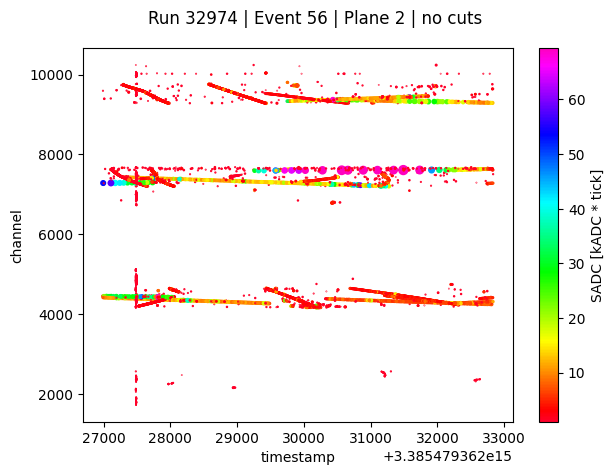

In [8]:
vmin, vmax = 1, (tps_32974["TP_SADC"].max()/1e3)/2
plt.figure()

tps = tps_32974[tps_32974.TP_plane == plane]
tps.run_name = "Cosmic run 32974"
sc = plt.scatter(tps.TP_peakT, tps.TP_channel, s=tps.TP_TOT / 10, c=tps.TP_SADC/1e3, cmap='gist_rainbow', vmin=vmin, vmax=vmax)
plt.xlabel("timestamp")
plt.ylabel("channel")

plt.suptitle(make_title(tps['run'].unique()[0], event, plane))
cbar = plt.colorbar(sc)
cbar.set_label("SADC [kADC * tick]")
plt.tight_layout()
plt.show()

In [9]:
print(f"TP_SADC: Minimum value {tps['TP_SADC'].min()/1e3}, maximum {(tps['TP_SADC'].max()/1e3)}, mean {tps['TP_SADC'].mean()/1e3}, std deviation {tps['TP_SADC'].std()/1e3}")
print(f"TP_PeakADC: Minimum value {tps['TP_peakADC'].min()}, maximum {(tps['TP_peakADC'].max())}, mean {tps['TP_peakADC'].mean()}, std deviation {tps['TP_peakADC'].std()}")
print(f"TP_TOT: Minimum value {tps['TP_TOT'].min()}, maximum {(tps['TP_TOT'].max())}, mean {tps['TP_TOT'].mean()}, std deviation {tps['TP_TOT'].std()}")


TP_SADC: Minimum value 0.061, maximum 138.8, mean 4.02704966425947, std deviation 6.5962281779196665
TP_PeakADC: Minimum value 61, maximum 3875, mean 372.8781198530343, std deviation 281.2000937872943
TP_TOT: Minimum value 1, maximum 414, mean 13.710756366400608, std deviation 15.949913116750578


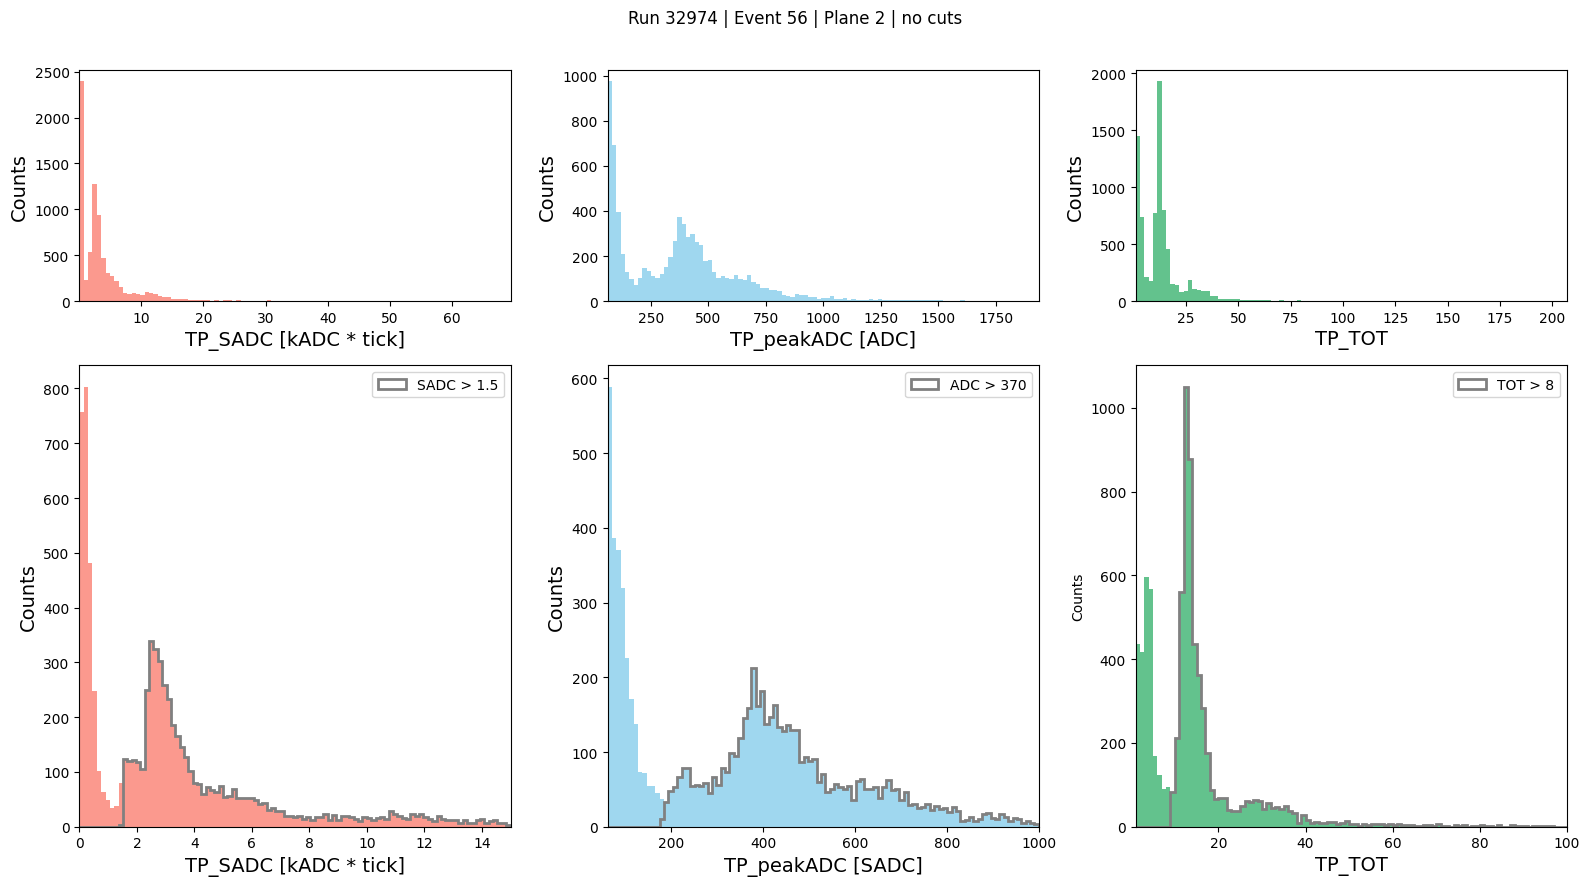

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(16, 9), gridspec_kw={'height_ratios': [1, 2]})

plt.suptitle(make_title(tps['run'].unique()[0], event, plane))

# 1. TP_SADC
bins_sadc = np.linspace(tps['TP_SADC'].min()/1e3, tps['TP_SADC'].max()/2e3, 100)
axs[0, 0].hist(tps['TP_SADC']/1e3, bins=bins_sadc, alpha=0.8, color='salmon')
axs[0, 0].set_xlabel('TP_SADC [kADC * tick]', fontsize=14)
axs[0, 0].set_ylabel('Counts', fontsize=14)
axs[0, 0].set_xlim(bins_sadc[0], bins_sadc[-1])

mask_sadc = (tps['TP_SADC']/1e3 >= 0) & (tps['TP_SADC']/1e3 <= 15)
tps_zoom_sadc = tps[mask_sadc]
bins_sadc_zoom = np.linspace(0, 15, 100)
axs[1, 0].hist(tps_zoom_sadc['TP_SADC']/1e3, bins=bins_sadc_zoom, alpha=0.8, color='salmon')
axs[1, 0].set_xlabel('TP_SADC [kADC * tick]', fontsize=14)
axs[1, 0].set_ylabel('Counts', fontsize=14)
axs[1, 0].set_xlim(bins_sadc_zoom[0], bins_sadc_zoom[-1])

threshold_sadc = 1.5
sadc_cut = tps_zoom_sadc[tps_zoom_sadc['TP_SADC']/1e3 > threshold_sadc]
axs[1, 0].hist(sadc_cut['TP_SADC']/1e3, bins=bins_sadc_zoom, histtype='step', color='gray', linewidth=2, label='SADC > 1.5')
axs[1, 0].legend()

# 2. TP_peakADC
bins_adc = np.linspace(tps['TP_peakADC'].min(), tps['TP_peakADC'].max()/2, 100)
axs[0, 1].hist(tps['TP_peakADC'], bins=bins_adc, alpha=0.8, color='skyblue')
axs[0, 1].set_xlabel('TP_peakADC [ADC]', fontsize=14)
axs[0, 1].set_ylabel('Counts', fontsize=14)
axs[0, 1].set_xlim(bins_adc[0], bins_adc[-1])

mask_adc = (tps['TP_peakADC'] >= 61) & (tps['TP_peakADC'] <= 1000)
tps_zoom_adc = tps[mask_adc]
bins_adc_zoom = np.linspace(61, 1000, 100)
axs[1, 1].hist(tps_zoom_adc['TP_peakADC'], bins=bins_adc_zoom, alpha=0.8, color='skyblue')
axs[1, 1].set_xlabel('TP_peakADC [SADC]', fontsize=14)
axs[1, 1].set_ylabel('Counts', fontsize=14)
axs[1, 1].set_xlim(bins_adc_zoom[0], bins_adc_zoom[-1])

threshold_adc = 180
adc_cut = tps_zoom_adc[tps_zoom_adc['TP_peakADC'] > threshold_adc]
axs[1, 1].hist(adc_cut['TP_peakADC'], bins=bins_adc_zoom, histtype='step', color='gray', linewidth=2, label='ADC > 370')
axs[1, 1].legend()

# 3. TP_TOT
bins_tot = np.linspace(tps['TP_TOT'].min(), tps['TP_TOT'].max()/2, 100)
axs[0, 2].hist(tps['TP_TOT'], bins=bins_tot, alpha=0.8, color='mediumseagreen')
axs[0, 2].set_xlabel('TP_TOT', fontsize=14)
axs[0, 2].set_ylabel('Counts', fontsize=14)
axs[0, 2].set_xlim(bins_tot[0], bins_tot[-1])

mask_tot = (tps['TP_TOT'] >= 1) & (tps['TP_TOT'] <= 100)
tps_zoom_tot = tps[mask_tot]
bins_tot_zoom = np.linspace(1, 100, 100)
axs[1, 2].hist(tps_zoom_tot['TP_TOT'], bins=bins_tot_zoom, alpha=0.8, color='mediumseagreen')
axs[1, 2].set_xlabel('TP_TOT', fontsize=14)
axs[1, 2].set_ylabel('Counts')
axs[1, 2].set_xlim(bins_tot_zoom[0], bins_tot_zoom[-1])

threshold_tot = 8
tot_cut = tps_zoom_tot[tps_zoom_tot['TP_TOT'] > threshold_tot]
axs[1, 2].hist(tot_cut['TP_TOT'], bins=bins_tot_zoom, histtype='step', color='gray', linewidth=2, label='TOT > 8')
axs[1, 2].legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- Clearly a presence of peak at lower energy and lower thresholds (noisier data)

    The small bump is connected to the actual presence of MIP

- The noise we are seeing i the small contribution of natural radioactivity of Liquid Argon 39

Total time for event: 5847 ticks, 0.0029235 s
Number of unique timestamps: 3611  of duration 500 ns
Mean duration between timestamps: 1.6196675900277009
Std deviation of durations: 1.3421365941758865
Min duration: 1
Max duration: 19


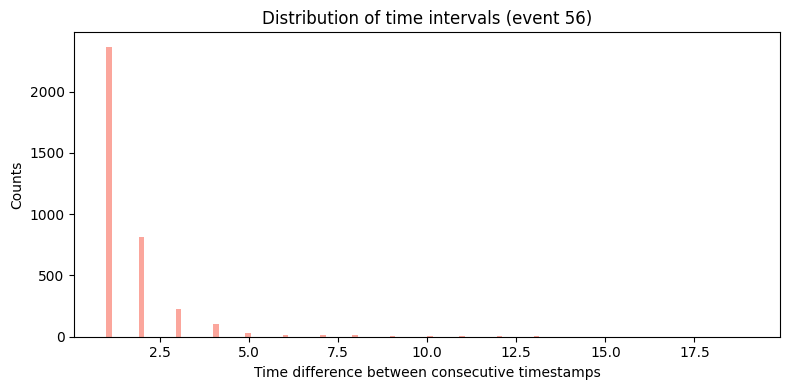

In [11]:
total_time = tps["TP_peakT"].max() - tps["TP_peakT"].min()
print(f"Total time for event: {total_time} ticks, {total_time*500/1e9} s") #ticks occur every 500 ns
num_timestamps = tps["TP_peakT"].nunique()
print("Number of unique timestamps:", num_timestamps, " of duration 500 ns")  #During event reconstruction and data storage, the same timestamp (tick value) is assigned to all channels/wires for that sampling instant.

# Time differences between consecutive timestamps
sorted_timestamps = np.sort(tps["TP_peakT"].unique())
time_diffs = np.diff(sorted_timestamps)
print("Mean duration between timestamps:", np.mean(time_diffs))
print("Std deviation of durations:", np.std(time_diffs))
print("Min duration:", np.min(time_diffs))
print("Max duration:", np.max(time_diffs))

plt.figure(figsize=(8,4))
plt.hist(time_diffs, bins=int(2*np.sqrt(len(time_diffs))), color='salmon', alpha=0.7)
plt.xlabel("Time difference between consecutive timestamps")
plt.ylabel("Counts")
plt.title("Distribution of time intervals (event {})".format(event))
plt.tight_layout()
plt.show()



- The readout is the ADC counts as a function of ticks, 500 ns on each channel. Each event spans 3s circa.  


- Many ticks have no new hit occuring (no threshold crossing). As a result the difference time between time stamps is differentS

## <a id='toc1_3_'></a>[Looking into thresholds and noise removal](#toc0_)

Threshold (TP_SADC): 1.5 (TPs: 5245, Retaining 66.45% of raw TP)


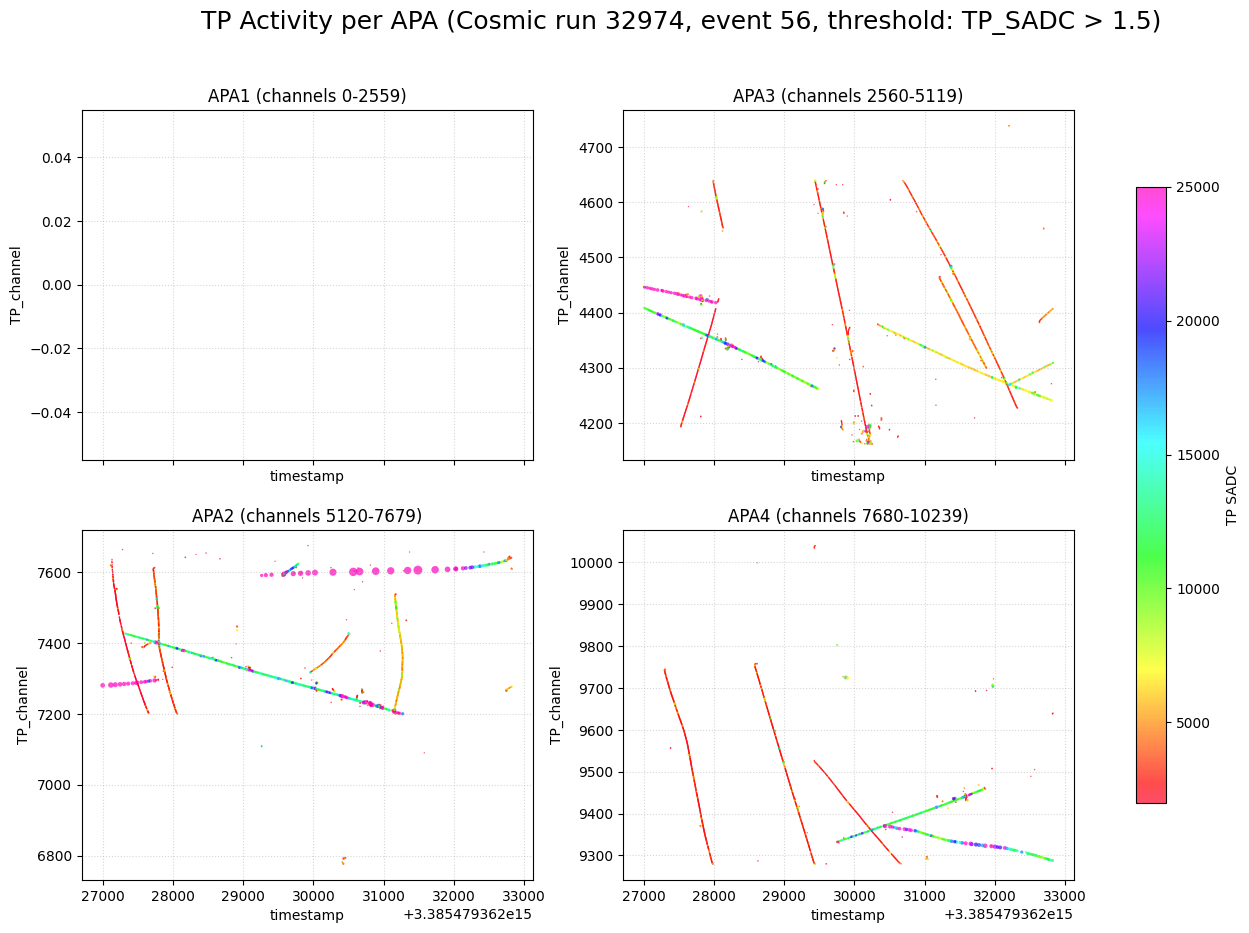

Threshold (TP_peakADC): 180 (TPs: 5366, Retaining 67.98% of raw TP)


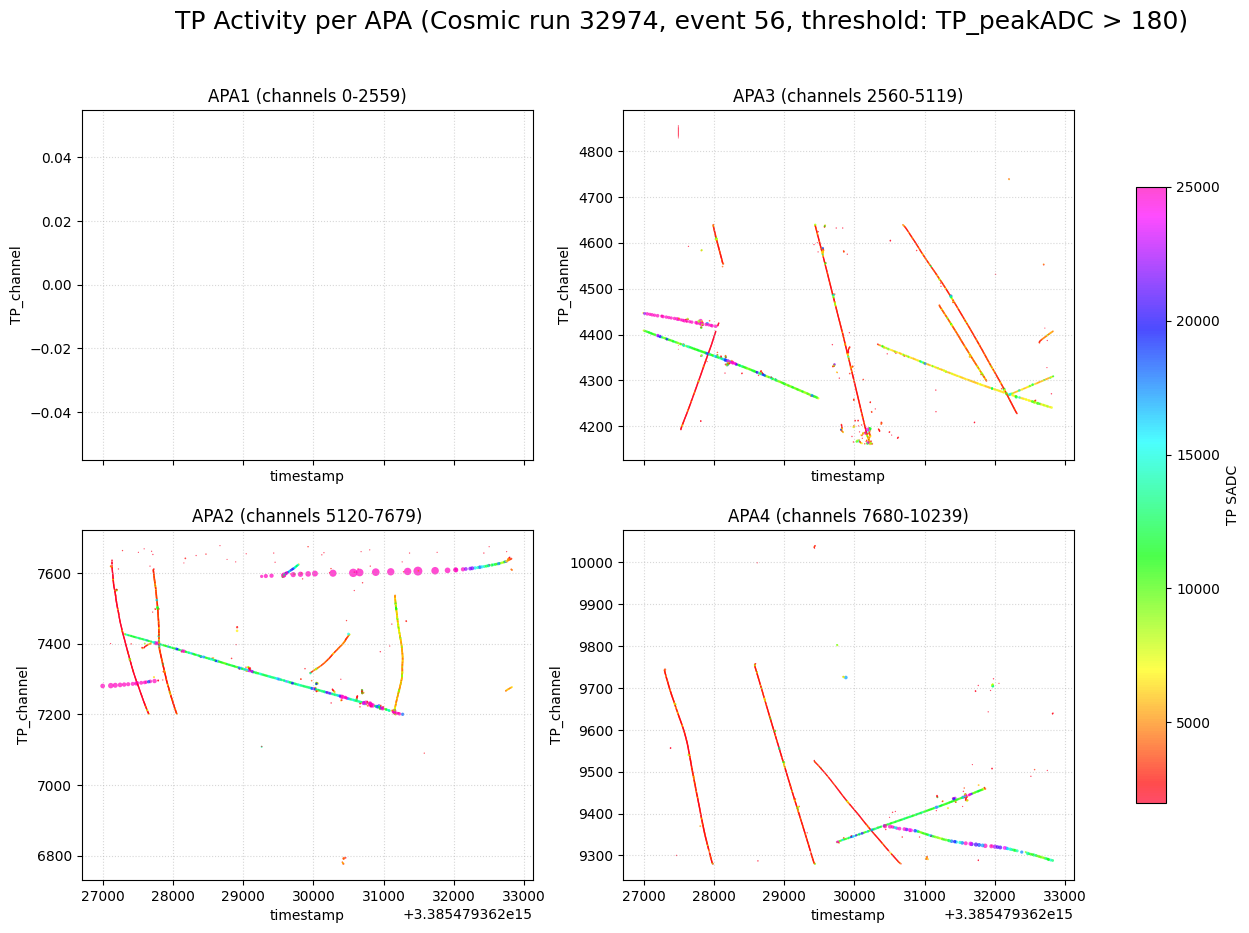

Threshold (TP_TOT): 8 (TPs: 5396, Retaining 68.36% of raw TP)


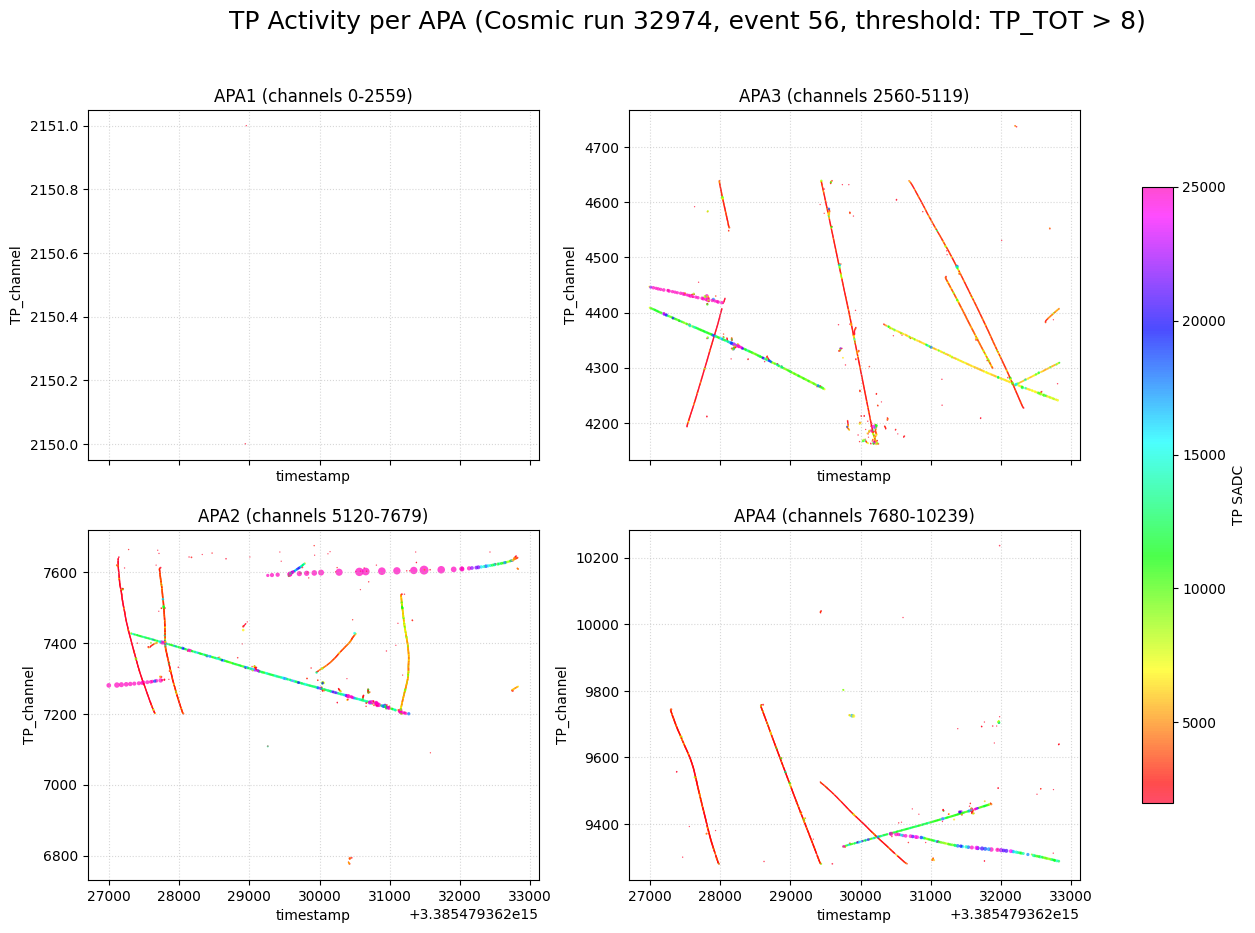

In [12]:
def plot_TPC_activity(tp_df, thresh, thresh_type="TP_peakADC", vmin=None, vmax=None, show_counts=True):
    """
    Creates scatter plots showing TP distribution across APAs with optional bar charts for TP counts. 
    Scatter plot point sizes are proportional to TP_TOT/10. Scatter plot colors represent TP_SADC values using 'gist_rainbow' colormap
    Data is filtered based on specified threshold criteria to remove noise.
    Creates 2x2 subplot grid for the 4 APAs in ProtoDUNE. Requires global variable 'apa_ranges' containing APA channel ranges

    ----------
    tp_df : pandas.DataFrame
        DataFrame containing trigger primitive data
        
    thresh : float
        Threshold value for filtering TPs. 
        
    thresh_type : str, optional
        Type of threshold to apply for filtering. Default is "TP_peakADC".
        Options:
        - "TP_peakADC": Filter by peak ADC value
        - "TP_TOT": Filter by time over threshold
        - "TP_SADC": Filter by sum ADC (divided by 1e3 for kADC units)
        
    vmin : float, optional
        Minimum value for colorbar scale in scatter plots. If None, uses data minimum.
        
    vmax : float, optional
        Maximum value for colorbar scale in scatter plots. If None, uses data maximum.
        
    show_counts : bool, optional
        Whether to display bar chart showing TP counts per APA. Default is True.
    """
    
    global apa_ranges 
    title_prefix = "TP Activity per APA"
    # Filter based on the threshold type
    if thresh_type == "TP_peakADC":
        filtered = tp_df[tp_df.TP_peakADC > thresh]
    elif thresh_type == "TP_TOT":
        filtered = tp_df[tp_df.TP_TOT > thresh]
    elif thresh_type == "TP_SADC":
        filtered = tp_df[tp_df.TP_SADC / 1e3 > thresh]
    else:
        raise ValueError(f"Unknown threshold type: {thresh_type}")

    print(f"Threshold ({thresh_type}): {thresh} (TPs: {len(filtered)}, Retaining {len(filtered)/len(tp_df)*100:.2f}% of raw TP)")
    run_type = tp_df.run_name if hasattr(tp_df, 'run_name') else "unknown_run"
    plot_title = f"{title_prefix} ({run_type}, event {event}, threshold: {thresh_type} > {thresh})"

    # --- Scatter plots ---
    fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
    for i, (apa, (start, stop)) in enumerate(apa_ranges.items()):
        ax = axs[i//2][i%2]
        df_apa = filtered[(filtered.TP_channel >= start) & (filtered.TP_channel < stop)]
        sc = ax.scatter(
            df_apa.TP_peakT, df_apa.TP_channel,
            s=df_apa.TP_TOT / 10,
            c=df_apa.TP_SADC,
            cmap="gist_rainbow",
            alpha=0.7,
            edgecolor="none",
            vmin=vmin, vmax=vmax
        )
        ax.set_title(f"{apa} (channels {start}-{stop-1})")
        ax.set_xlabel("timestamp")
        ax.set_ylabel("TP_channel")
        ax.grid(True, linestyle="dotted", alpha=0.5)

    plt.suptitle(f"{plot_title}", fontsize=18)
    fig.colorbar(sc, ax=axs, orientation="vertical", shrink=0.8, label="TP SADC")
    plt.show()

    # --- Bar plot: TP count per APA ---
    if show_counts:
        apa_counts = [
            len(filtered[(filtered.TP_channel >= start) & (filtered.TP_channel < stop)])
            for (start, stop) in apa_ranges.values()
        ]
        plt.figure(figsize=(8, 5))
        plt.bar(apa_ranges.keys(), apa_counts, color='steelblue')
        plt.ylabel("Number of TPs")
        plt.title(f"Total TP Count per APA ({thresh_type} > {thresh})")
        plt.show()

# For SADC threshold
plot_TPC_activity(tps, threshold_sadc, 
            vmin=2000, vmax=25000, thresh_type="TP_SADC", show_counts=False)

# For ADC threshold
plot_TPC_activity(tps, threshold_adc, 
            vmin=2000, vmax=25000, thresh_type="TP_peakADC", show_counts=False)

# For TOT threshold
plot_TPC_activity(tps, threshold_tot, 
            vmin=2000, vmax=25000, thresh_type="TP_TOT", show_counts=False)

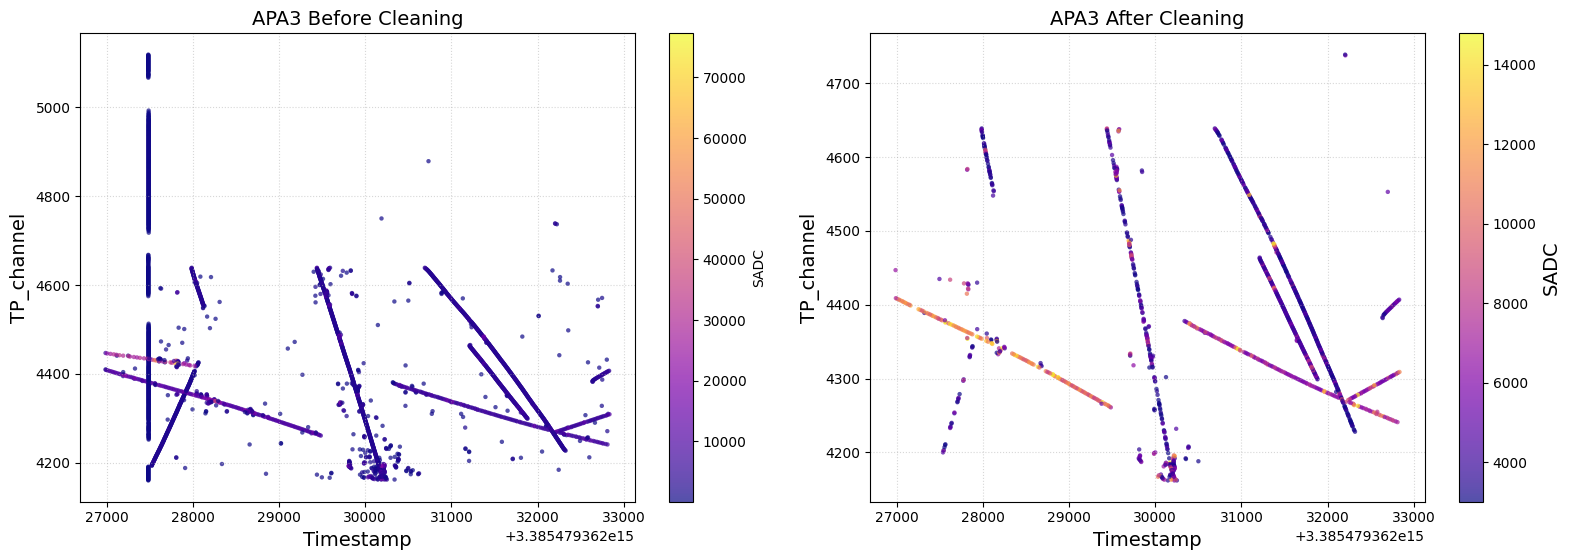

In [13]:
apa_name = "APA3"
start, stop = 2560, 5120
sadc_min, sadc_max = 3000, 15000

# --- BEFORE CLEANING: Mask for APA3, Collection Plane ---
apa3_mask = ((tps['TP_channel'] >= start) & (tps['TP_channel'] < stop))

df_before = tps[apa3_mask]

# --- AFTER CLEANING: Apply SADC and peakADC cut ---
apa3_clean_mask = apa3_mask & (tps['TP_SADC'] >= sadc_min) & (tps['TP_SADC'] <= sadc_max) & (tps['TP_TOT'] > 8)
df_after = tps[apa3_clean_mask]

plt.figure(figsize=(16, 6))

# Before cleaning
plt.subplot(1, 2, 1)
sc1 = plt.scatter(
    df_before['TP_peakT'], df_before['TP_channel'],
    c=df_before['TP_SADC'], cmap='plasma', s=10, alpha=0.7, edgecolor="none"
)
plt.xlabel("Timestamp", fontsize=14)
plt.ylabel("TP_channel", fontsize=14)
plt.title(f"{apa_name} Before Cleaning", fontsize=14)
cbar1 = plt.colorbar(sc1)
cbar1.set_label("SADC")
plt.grid(True, linestyle="dotted", alpha=0.5)
# After cleaning
plt.subplot(1, 2, 2)
sc2 = plt.scatter(
    df_after['TP_peakT'], df_after['TP_channel'],
    c=df_after['TP_SADC'], cmap='plasma', s=10, alpha=0.7, edgecolor="none"
)
plt.xlabel("Timestamp", fontsize=14)
plt.ylabel("TP_channel", fontsize=14)
plt.title(f"{apa_name} After Cleaning", fontsize=14)
cbar2 = plt.colorbar(sc2)
cbar2.set_label("SADC", fontsize=14)
plt.grid(True, linestyle="dotted", alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## <a id='toc1_4_'></a>[Spatial distribution](#toc0_)

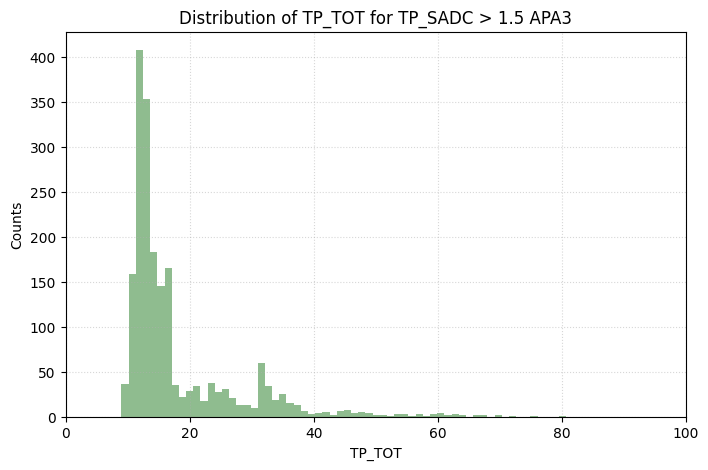

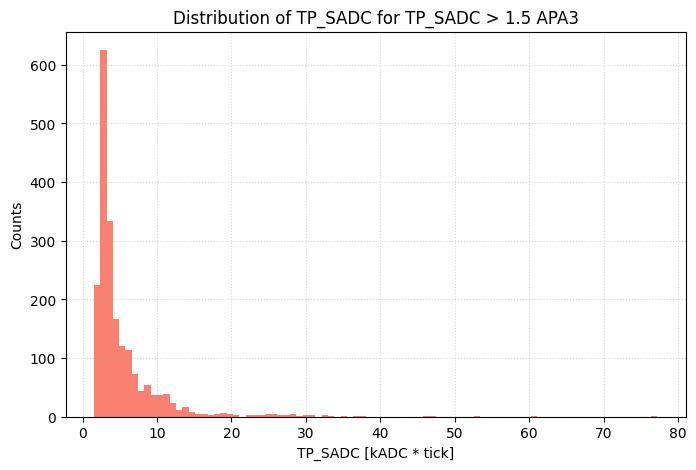

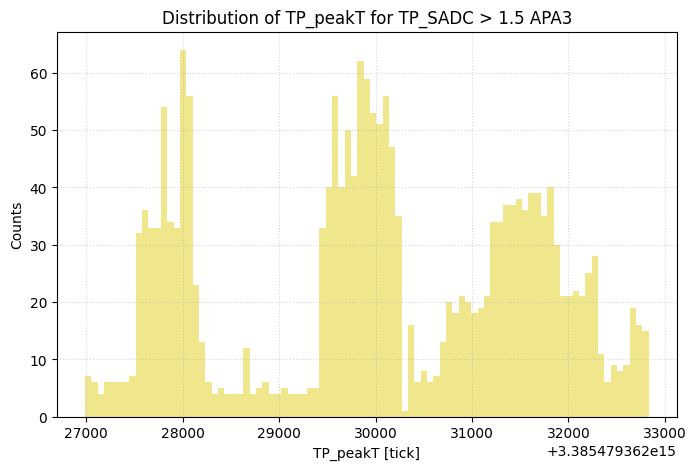

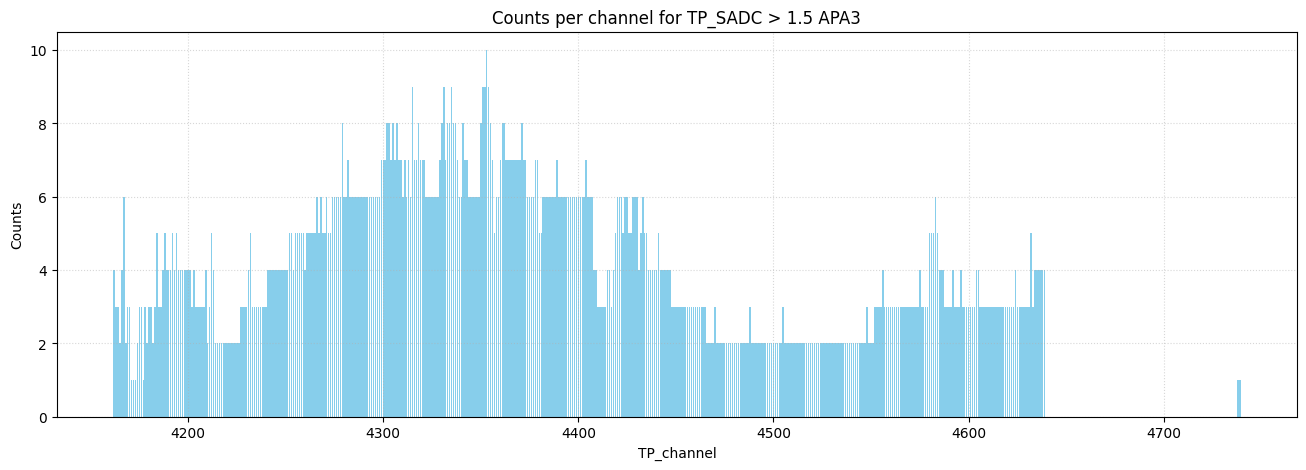

In [14]:
filtered_tps= tps[tps.TP_SADC / 1e3 > threshold_sadc]
filtered_APA3=filtered_tps[(filtered_tps.TP_channel>=apa_ranges["APA3"][0]) & (filtered_tps.TP_channel<apa_ranges["APA3"][1])]

# Plot TP_TOT distribution for filtered data by SADC threshold
plt.figure(figsize=(8,5))
plt.hist(filtered_APA3.TP_TOT, bins=int(2*np.sqrt(len(filtered_APA3))), color='darkseagreen')
plt.xlabel("TP_TOT")
plt.ylabel("Counts")
plt.title(f"Distribution of TP_TOT for TP_SADC > {threshold_sadc} APA3")
plt.xlim(0, 100)
plt.grid(True, linestyle="dotted", alpha=0.5)
plt.show()

# Plot TP_peakT distribution for filtered data by SADC threshold
plt.figure(figsize=(8,5))
#plt.hist(filtered.TP_peakT, bins=int(2*np.sqrt(len(filtered))), color='salmon')
plt.hist(filtered_APA3.TP_SADC/1e3, bins=int(2*np.sqrt(len(filtered_APA3))), color='salmon')
plt.xlabel("TP_SADC [kADC * tick]")
plt.ylabel("Counts")
plt.title(f"Distribution of TP_SADC for TP_SADC > {threshold_sadc} APA3")
plt.grid(True, linestyle="dotted", alpha=0.5)
plt.show()

# Plot TP_peakT distribution for filtered data by SADC threshold
plt.figure(figsize=(8,5))
plt.hist(filtered_APA3.TP_peakT, bins=int(2*np.sqrt(len(filtered_APA3))), color='khaki')
plt.xlabel("TP_peakT [tick]")
plt.ylabel("Counts")
plt.title(f"Distribution of TP_peakT for TP_SADC > {threshold_sadc} APA3")
plt.grid(True, linestyle="dotted", alpha=0.5)
plt.show()

# Plot counts x channel distribution for filtered data by SADC threshold
plt.figure(figsize=(16,5))
channel_counts = filtered_APA3.TP_channel.value_counts().sort_index()
plt.bar(channel_counts.index, channel_counts.values, color='skyblue')
plt.xlabel("TP_channel")
plt.ylabel("Counts")
plt.title(f"Counts per channel for TP_SADC > {threshold_sadc} APA3")
plt.grid(True, linestyle="dotted", alpha=0.5)
plt.show()

In [ ]:
# Suddivisione per TP_TOT
space_like = filtered_APA3[filtered_APA3["TP_TOT"] < 25]
time_like = filtered_APA3[(filtered_APA3["TP_TOT"] >= 25)]

<Figure size 640x480 with 0 Axes>

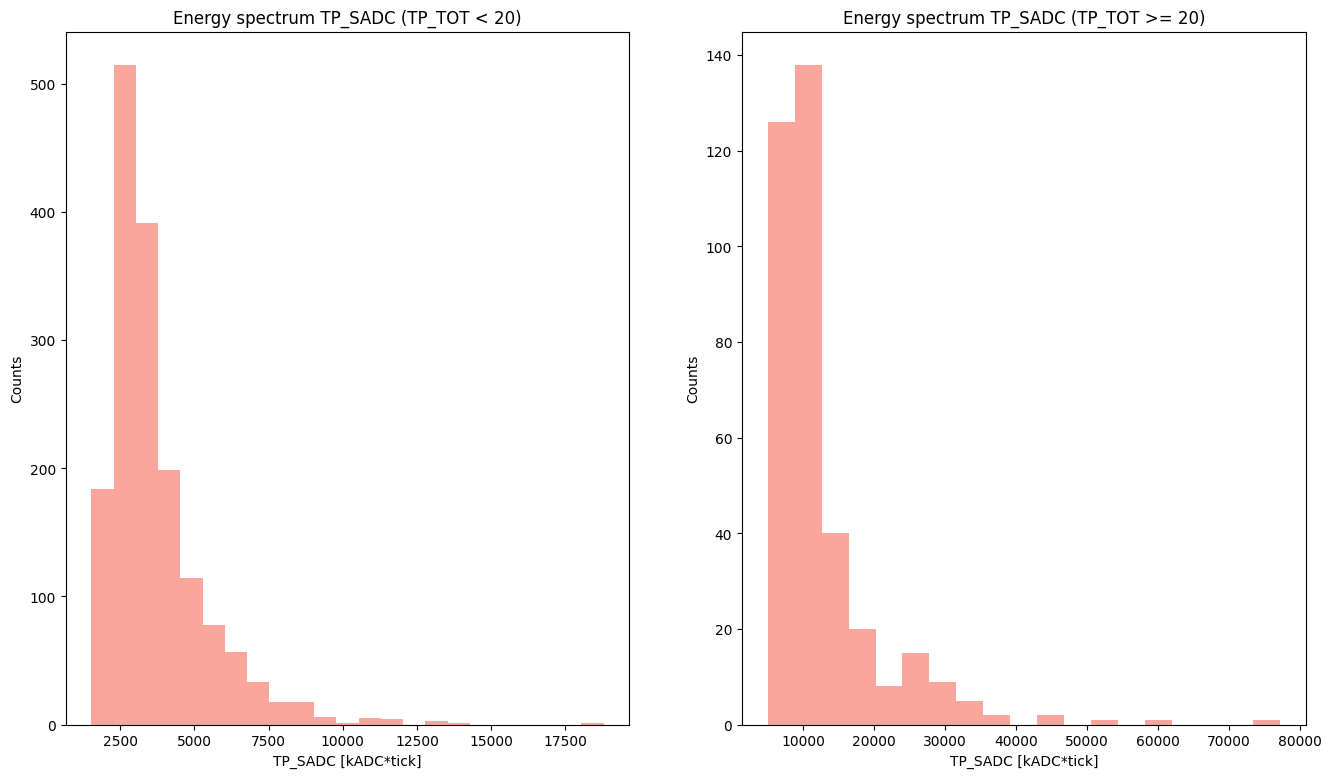

In [ ]:
def sturges_bins(array):
    return int(np.ceil(1 + 2*np.log2(len(array))))

plt.suptitle(make_title(tps['run'].unique()[0], event, plane) + " | APA3")

fig, axs = plt.subplots(1, 2, figsize=(16, 9))

# space_like
axs[0].hist(space_like["TP_SADC"], bins=sturges_bins(space_like["TP_SADC"]), alpha=0.7, color="salmon")
axs[0].set_xlabel("TP_SADC [kADC*tick]")
axs[0].set_ylabel("Counts")
axs[0].set_title("Energy spectrum TP_SADC (TP_TOT < 20)")

# Tracce lunghe
axs[1].hist(time_like["TP_SADC"], bins=sturges_bins(time_like["TP_SADC"]), alpha=0.7, color="salmon")
axs[1].set_xlabel("TP_SADC [kADC*tick]")
axs[1].set_ylabel("Counts")
axs[1].set_title("Energy spectrum TP_SADC (TP_TOT >= 20)")

plt.show()

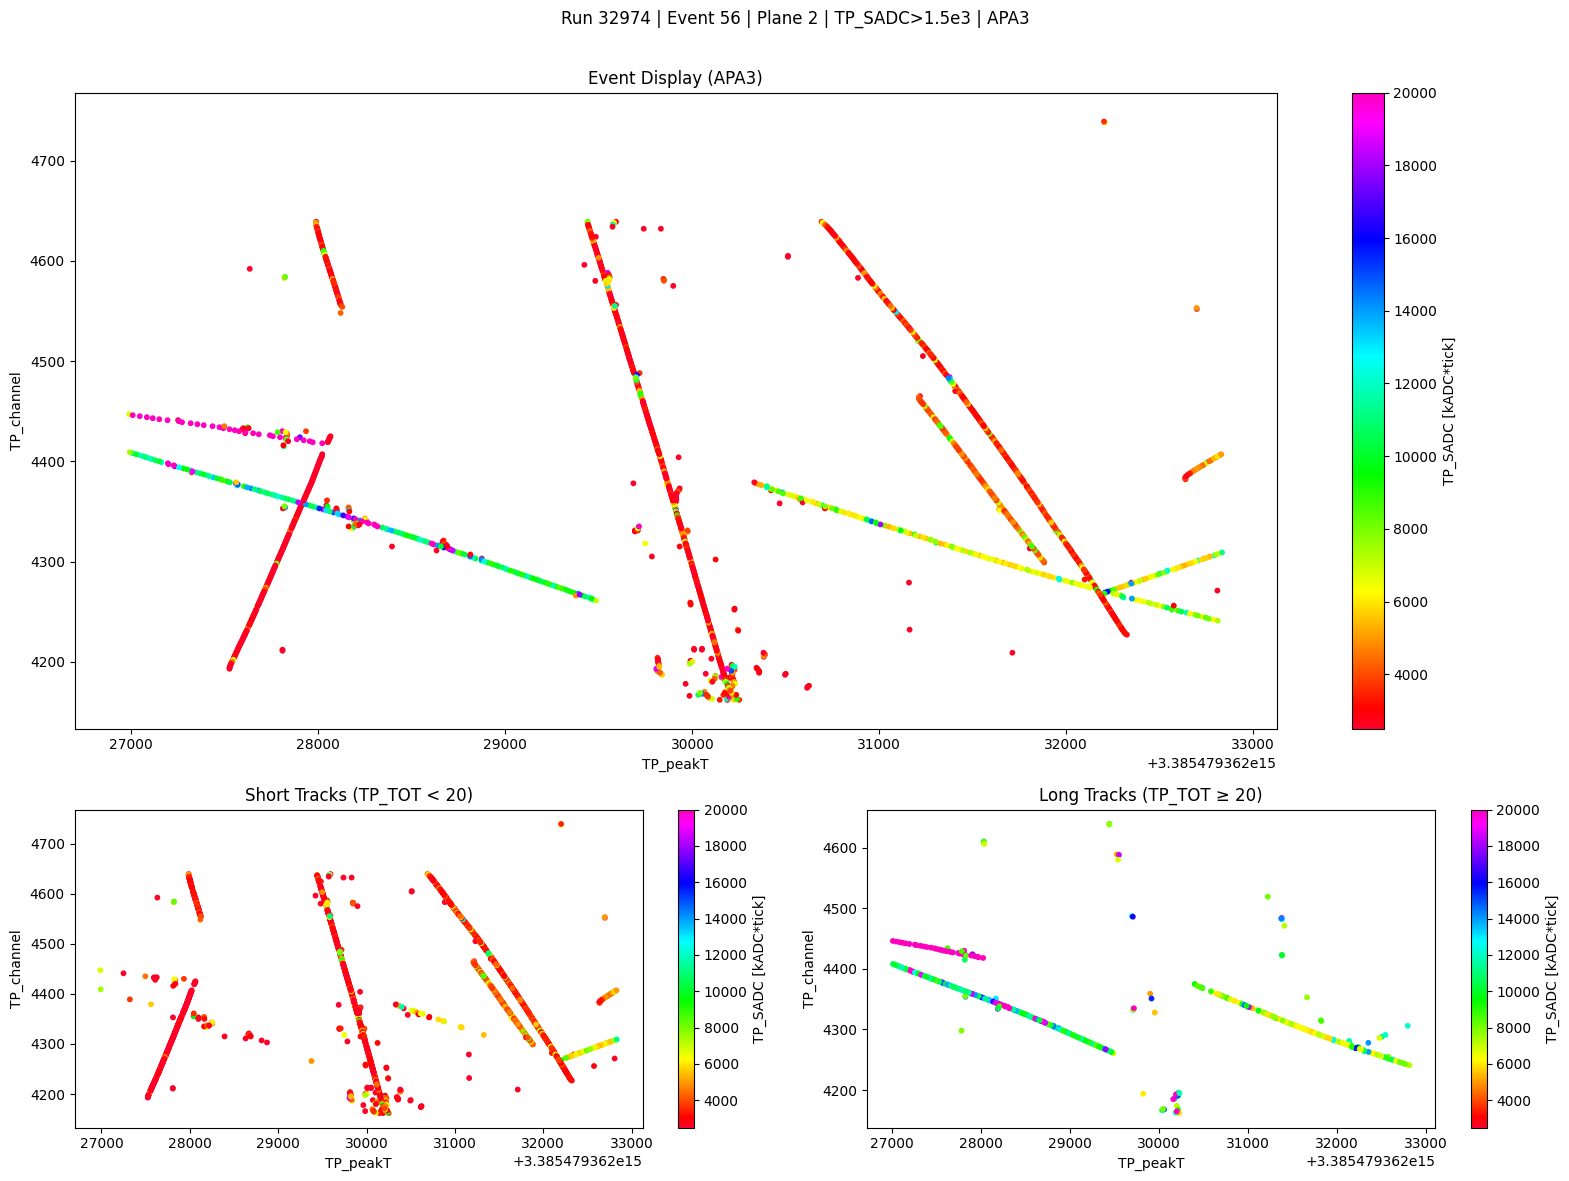

In [ ]:
fig = plt.figure(figsize=(16, 12))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])

plt.suptitle(make_title(tps['run'].unique()[0], event, plane, "TP_SADC>1.5e3") + " | APA3")

cmap = "gist_rainbow"
vmin, vmax = 2500, 20000

# First row: APA3 event display spans both columns
ax0 = fig.add_subplot(gs[0, :])
sc0 = ax0.scatter(
    filtered_APA3["TP_peakT"],
    filtered_APA3["TP_channel"],
    s=10,
    c=filtered_APA3["TP_SADC"],
    cmap=cmap,
    vmin=vmin,
    vmax=vmax
)
ax0.set_title("Event Display (APA3)")
ax0.set_ylabel("TP_channel")
ax0.set_xlabel("TP_peakT")
cbar0 = plt.colorbar(sc0, ax=ax0)
cbar0.set_label("TP_SADC [kADC*tick]")

# Second row, left: short tracks
ax1 = fig.add_subplot(gs[1, 0])
sc1 = ax1.scatter(
    space_like["TP_peakT"],
    space_like["TP_channel"],
    s=10,
    c=space_like["TP_SADC"],
    cmap=cmap,
    vmin=vmin,
    vmax=vmax
)
ax1.set_title("Short Tracks (TP_TOT < 20)")
ax1.set_ylabel("TP_channel")
ax1.set_xlabel("TP_peakT")
cbar1 = plt.colorbar(sc1, ax=ax1)
cbar1.set_label("TP_SADC [kADC*tick]")

# Second row, right: long tracks
ax2 = fig.add_subplot(gs[1, 1])
sc2 = ax2.scatter(
    time_like["TP_peakT"],
    time_like["TP_channel"],
    s=10,
    c=time_like["TP_SADC"],
    cmap=cmap,
    vmin=vmin,
    vmax=vmax
)
ax2.set_title("Long Tracks (TP_TOT ≥ 20)")
ax2.set_ylabel("TP_channel")
ax2.set_xlabel("TP_peakT")
cbar2 = plt.colorbar(sc2, ax=ax2)
cbar2.set_label("TP_SADC [kADC*tick]")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

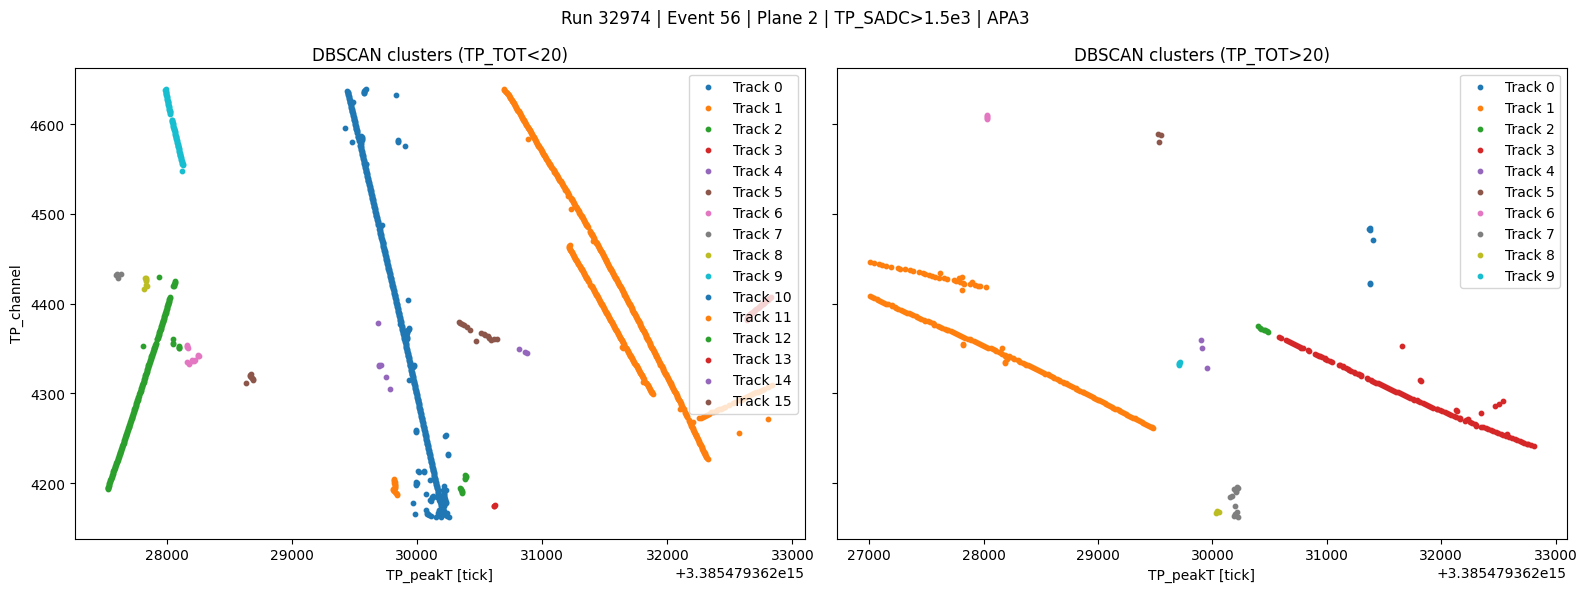

Silhouette (long tracks): -0.8848796585674491
Silhouette (short tracks): -0.9136665138104921


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
# Prepare features
X_time = time_like[['TP_peakT', 'TP_channel']].values
X_space = space_like[['TP_peakT', 'TP_channel']].values

# DBSCAN clustering
eps = 60
min_samples = 3
db_long = DBSCAN(eps=eps, min_samples=min_samples).fit(X_time)
labels_long = db_long.labels_

db_short = DBSCAN(eps=eps, min_samples=min_samples).fit(X_space)
labels_short = db_short.labels_

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.suptitle(make_title(tps['run'].unique()[0], event, plane, "TP_SADC>1.5e3") + " | APA3")

# Left subplot: short tracks
axes[0].set_title('DBSCAN clusters (TP_TOT<20)')
for lbl in set(labels_short):
    if lbl == -1:
        continue  # skip noise
    pts = X_space[labels_short == lbl]
    axes[0].scatter(pts[:,0], pts[:,1], label=f'Track {lbl}', s=10)
axes[0].set_xlabel('TP_peakT [tick]')
axes[0].set_ylabel('TP_channel')
axes[0].legend()

# Right subplot: long tracks
axes[1].set_title('DBSCAN clusters (TP_TOT>20)')
for lbl in set(labels_long):
    if lbl == -1:
        continue  # skip noise
    pts = X_time[labels_long == lbl]
    axes[1].scatter(pts[:,0], pts[:,1], label=f'Track {lbl}', s=10)
axes[1].set_xlabel('TP_peakT [tick]')
axes[1].legend()

plt.tight_layout()
plt.show()

print('Silhouette (long tracks): %s' % metrics.silhouette_score(X_time, labels_long))
print('Silhouette (short tracks): %s' % metrics.silhouette_score(X_space, labels_short))

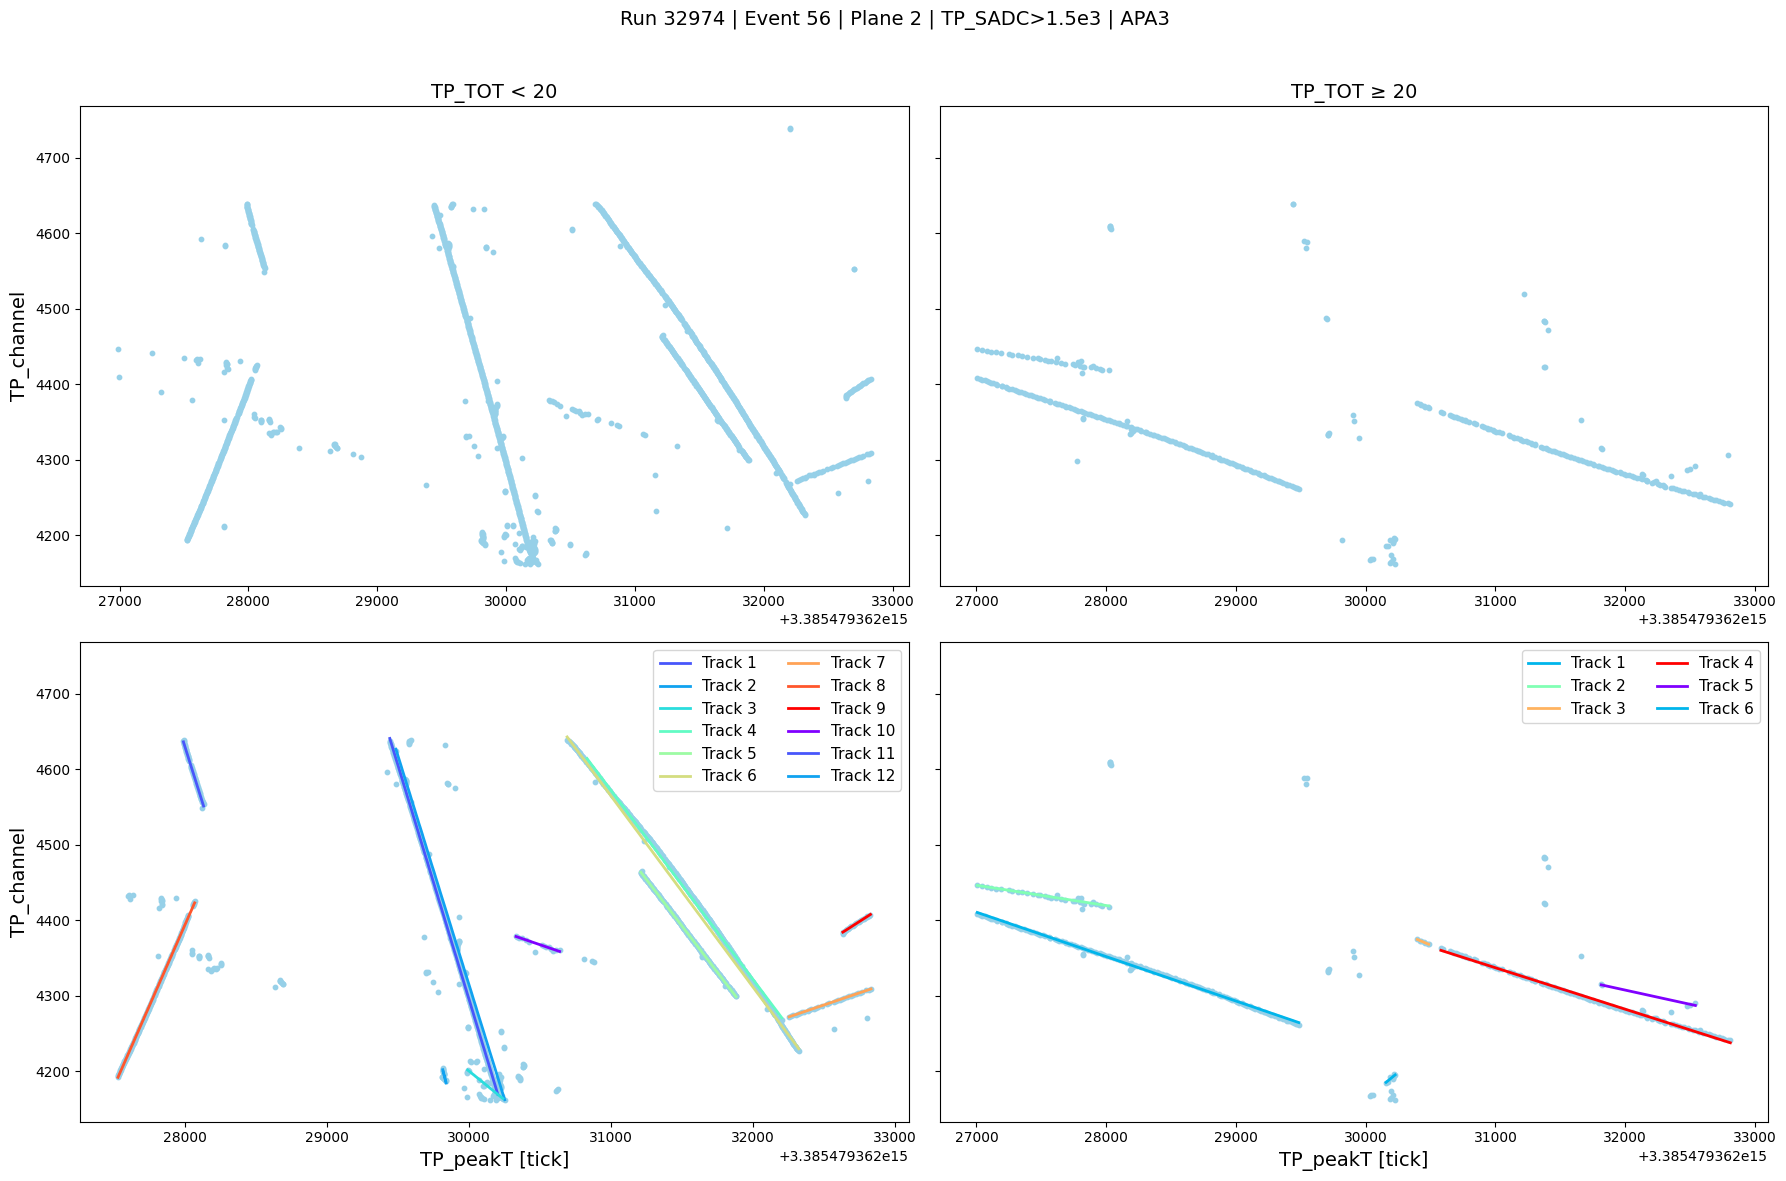

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.linear_model import RANSACRegressor, LinearRegression

# --- DBSCAN clustering ---
eps = 60
min_samples = 3
X_time = time_like[['TP_peakT', 'TP_channel']].values
X_space = space_like[['TP_peakT', 'TP_channel']].values
db_long = DBSCAN(eps=eps, min_samples=min_samples).fit(X_time)
labels_long = db_long.labels_
db_short = DBSCAN(eps=eps, min_samples=min_samples).fit(X_space)
labels_short = db_short.labels_

# --- Plot ---
fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharex=False, sharey=True)
plt.suptitle(make_title(tps['run'].unique()[0], event, plane, "TP_SADC>1.5e3") + " | APA3", fontsize=14)
# --- Top left: raw data, short tracks ---
axes[0, 0].set_title('TP_TOT < 20', fontsize=14)
axes[0, 0].scatter(space_like["TP_peakT"], space_like["TP_channel"], s=10, color="#96D0E8")
axes[0, 0].set_ylabel('TP_channel', fontsize=14)

# --- Top right: raw data, long tracks ---
axes[0, 1].set_title('TP_TOT ≥ 20', fontsize=14)
axes[0, 1].scatter(time_like["TP_peakT"], time_like["TP_channel"], s=10, color="#96D0E8")

# --- Bottom left: clusters & Ridge tracks, short tracks ---
track_number = 1
track_colors_short = plt.cm.rainbow(np.linspace(0, 1, 10))  # Up to 30 tracks
for lbl in set(labels_short):
    if lbl == -1:
        continue  # skip noise
    pts = X_space[labels_short == lbl]
    axes[1, 0].scatter(pts[:,0], pts[:,1], s=10, color="#96D0E8")
    cluster_points = pts.copy()
    while len(cluster_points) >= 12:
        model = RANSACRegressor(LinearRegression(), residual_threshold=5, min_samples=4)
        model.fit(cluster_points[:,0].reshape(-1,1), cluster_points[:,1])
        inlier_mask = model.inlier_mask_
        if np.sum(inlier_mask) < 12:
            break
        x_in = cluster_points[:,0][inlier_mask]
        x_fit = np.linspace(x_in.min(), x_in.max(), 100)
        y_fit = model.predict(x_fit.reshape(-1,1))
        color = track_colors_short[track_number % len(track_colors_short)]
        axes[1, 0].plot(x_fit, y_fit, '-', label=f'Track {track_number}', linewidth=2, color=color)
        track_number += 1
        cluster_points = cluster_points[~inlier_mask]
axes[1, 0].set_xlabel('TP_peakT [tick]', fontsize=14)
axes[1, 0].set_ylabel('TP_channel', fontsize=14)
axes[1, 0].legend(ncol=2, fontsize=11)

# --- Bottom right: clusters & Ridge tracks, long tracks ---
track_number = 1
track_colors_long = plt.cm.rainbow(np.linspace(0, 1, 5))  # Up to 30 tracks
for lbl in set(labels_long):
    if lbl == -1:
        continue  # skip noise
    pts = X_time[labels_long == lbl]
    axes[1, 1].scatter(pts[:,0], pts[:,1], s=10, color="#96D0E8")
    cluster_points = pts.copy()
    while len(cluster_points) >= 7:
        model = RANSACRegressor(LinearRegression(), residual_threshold=5, min_samples=4)
        model.fit(cluster_points[:,0].reshape(-1,1), cluster_points[:,1])
        inlier_mask = model.inlier_mask_
        if np.sum(inlier_mask) < 4:
            break
        x_in = cluster_points[:,0][inlier_mask]
        x_fit = np.linspace(x_in.min(), x_in.max(), 100)
        y_fit = model.predict(x_fit.reshape(-1,1))
        color = track_colors_long[track_number % len(track_colors_long)]
        axes[1, 1].plot(x_fit, y_fit, '-', label=f'Track {track_number}', linewidth=2, color=color)
        track_number += 1
        cluster_points = cluster_points[~inlier_mask]
axes[1, 1].set_xlabel('TP_peakT [tick]', fontsize=14)
axes[1, 1].legend(ncol=2, fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

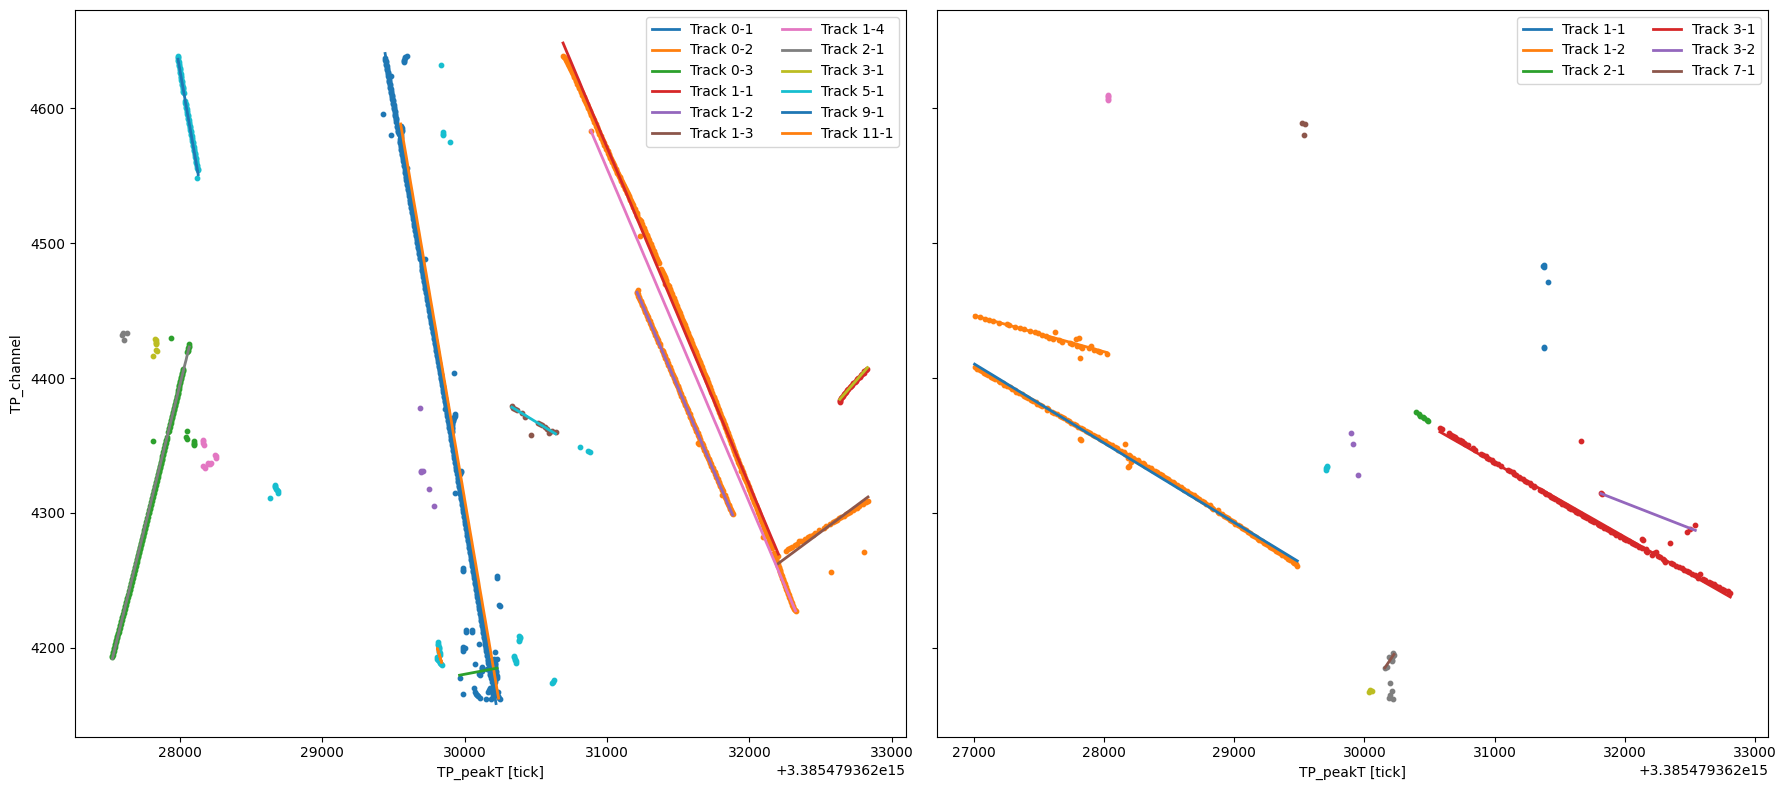

,track_type,cluster_label,track_index,n_points,TP_peakT_min,TP_peakT_max,TP_channel_min,TP_channel_max,track_length,TP_SADC_sum,TP_SADC_mean,slope,fluctuation,TP_channel_mean,TP_peakT_mean
0,short,0,0,464,3385479361729441,3385479361730220,4166,4637,779,0,0.0,6.502622e-13,0.0,4402.898707,3.385479e+15
1,short,0,1,22,3385479361729550,3385479361730238,4163,4587,688,0,0.0,-6.184939e-01,0.0,4382.136364,3.385479e+15
2,short,0,2,22,3385479361729964,3385479361730228,4178,4192,264,0,0.0,2.044218e-02,0.0,4183.954545,3.385479e+15
3,short,1,0,371,3385479361730691,3385479361732204,4262,4639,1513,0,0.0,6.575235e-13,0.0,4452.064690,3.385479e+15
4,short,1,1,165,3385479361731211,3385479361731882,4299,4465,671,0,0.0,6.471336e-13,0.0,4381.715152,3.385479e+15
5,short,1,2,42,3385479361732201,3385479361732833,4254,4309,632,0,0.0,7.823350e-02,0.0,4284.023810,3.385479e+15
6,short,1,3,29,3385479361730886,3385479361732324,4227,4583,1438,0,0.0,-2.471815e-01,0.0,4253.275862,3.385479e+15
7,short,2,0,218,3385479361727525,3385479361728065,4193,4425,540,0,0.0,6.355272e-13,0.0,4303.128440,3.385479e+15
8,short,3,0,26,3385479361732635,3385479361732829,4382,4407,194,0,0.0,1.209569e-01,0.0,4394.500000,3.385479e+15
9,short,5,0,14,3385479361730331,3385479361730638,4359,4379,307,0,0.0,-6.424828e-02,0.0,4368.500000,3.385479e+15


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18,8), sharey=True)

tracks_short = []  # Lista per tracce corte
min_points_line = 12
residual_threshold = 8

for ci, lbl in enumerate(set(labels_short)):
    if lbl == -1:
        continue
    pts = X_space[labels_short == lbl]
    axes[0].scatter(pts[:,0], pts[:,1], s=10, color=plt.cm.tab10(ci))
    cluster_points = pts.copy()
    tracks_found = 0
    while len(cluster_points) >= min_points_line:
        model = RANSACRegressor(LinearRegression(), residual_threshold=residual_threshold, min_samples=min_points_line)
        model.fit(cluster_points[:,0].reshape(-1,1), cluster_points[:,1])
        inlier_mask = model.inlier_mask_
        if np.sum(inlier_mask) < min_points_line:
            break

        # Salva le proprietà della traccia trovata
        x_in = cluster_points[:,0][inlier_mask]
        y_in = cluster_points[:,1][inlier_mask]
        sadc_in = None
        if pts.shape[1] > 2:
            sadc_in = cluster_points[:,2][inlier_mask]
        else:
            sadc_in = np.zeros_like(x_in)
        track_length = x_in.max() - x_in.min()
        energy_sum = sadc_in.sum()
        energy_mean = sadc_in.mean()
        slope = np.polyfit(x_in, y_in, 1)[0] if len(x_in) >= 2 else np.nan
        fluctuation = np.std(sadc_in) if len(sadc_in) > 1 else np.nan

        tracks_short.append({
            'track_type': 'short',
            'cluster_label': lbl,
            'track_index': tracks_found,
            'n_points': len(x_in),
            'TP_peakT_min': x_in.min(),
            'TP_peakT_max': x_in.max(),
            'TP_channel_min': y_in.min(),
            'TP_channel_max': y_in.max(),
            'track_length': track_length,
            'TP_SADC_sum': energy_sum,
            'TP_SADC_mean': energy_mean,
            'slope': slope,
            'fluctuation': fluctuation,
            'TP_channel_mean': y_in.mean(),
            'TP_peakT_mean': x_in.mean(),
        })

        # Plot
        x_fit = np.linspace(x_in.min(), x_in.max(), 100)
        y_fit = model.predict(x_fit.reshape(-1,1))
        axes[0].plot(x_fit, y_fit, '-', label=f'Track {lbl}-{tracks_found+1}', linewidth=2)
        tracks_found += 1
        cluster_points = cluster_points[~inlier_mask]
axes[0].set_xlabel('TP_peakT [tick]')
axes[0].set_ylabel('TP_channel')
axes[0].legend(ncol=2)

# --- Fai lo stesso per tracce lunghe! ---
tracks_long = []
for ci, lbl in enumerate(set(labels_long)):
    if lbl == -1:
        continue
    pts = X_time[labels_long == lbl]
    axes[1].scatter(pts[:,0], pts[:,1], s=10, color=plt.cm.tab10(ci))
    cluster_points = pts.copy()
    tracks_found = 0
    while len(cluster_points) >= 7:
        model = RANSACRegressor(LinearRegression(), residual_threshold=5, min_samples=4)
        model.fit(cluster_points[:,0].reshape(-1,1), cluster_points[:,1])
        inlier_mask = model.inlier_mask_
        if np.sum(inlier_mask) < 4:
            break
        x_in = cluster_points[:,0][inlier_mask]
        y_in = cluster_points[:,1][inlier_mask]
        sadc_in = None
        if pts.shape[1] > 2:
            sadc_in = cluster_points[:,2][inlier_mask]
        else:
            sadc_in = np.zeros_like(x_in)
        track_length = x_in.max() - x_in.min()
        energy_sum = sadc_in.sum()
        energy_mean = sadc_in.mean()
        slope = np.polyfit(x_in, y_in, 1)[0] if len(x_in) >= 2 else np.nan
        fluctuation = np.std(sadc_in) if len(sadc_in) > 1 else np.nan

        tracks_long.append({
            'track_type': 'long',
            'cluster_label': lbl,
            'track_index': tracks_found,
            'n_points': len(x_in),
            'TP_peakT_min': x_in.min(),
            'TP_peakT_max': x_in.max(),
            'TP_channel_min': y_in.min(),
            'TP_channel_max': y_in.max(),
            'track_length': track_length,
            'TP_SADC_sum': energy_sum,
            'TP_SADC_mean': energy_mean,
            'slope': slope,
            'fluctuation': fluctuation,
            'TP_channel_mean': y_in.mean(),
            'TP_peakT_mean': x_in.mean(),
        })

        # Plot
        x_fit = np.linspace(x_in.min(), x_in.max(), 100)
        y_fit = model.predict(x_fit.reshape(-1,1))
        axes[1].plot(x_fit, y_fit, '-', label=f'Track {lbl}-{tracks_found+1}', linewidth=2)
        tracks_found += 1
        cluster_points = cluster_points[~inlier_mask]
axes[1].set_xlabel('TP_peakT [tick]')
axes[1].legend(ncol=2)

plt.tight_layout()
plt.show()

# --- DataFrame finale delle tracce ---
df_tracks = pd.DataFrame(tracks_short + tracks_long)
display(df_tracks)